# Transformer로 번역기 만들기
# 프로젝트: 더 멋진 번역기 만들기

#### 라이브러리 버전 확인

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import sequence

import re
import os
import io
import time
import random

from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
from tqdm import tqdm
from tqdm import tqdm_notebook
import sentencepiece as spm
import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## 데이터 정제 및 토큰화

set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거한다

데이터의 병렬 쌍이 흐트러지지 않게 주의해야한다. 중복을 제거한 데이터를 cleaned_corpus 에 저장한다

In [5]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)
len(cleaned_corpus)

78968

In [6]:
cleaned_corpus[100]

('개주인 매리 플러드는 제이크와 함께 들밭을 거닐고 계곡에 몸을 당군 후 마지막 산보를 마치고 돌아와 개를 안락사시켰다.',
 'Owner Mary Flood had 12-year-old Jake put to sleep Wednesday after a last stroll through the fields and a dip in the creek near their home in Oakley, Utah.')

#### 정제 함수를 조건에 맞게 정의하자

모든 입력을 소문자로 변환합니다.

알파벳, 문장부호, 한글만 남기고 모두 제거합니다.

문장부호 양옆에 공백을 추가합니다.

문장 앞뒤의 불필요한 공백을 제거합니다.

In [7]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower()

    sentence = re.sub(r"([?.!,¿¡])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-하-ㅣ가-힣0-9?.!,]+", " ", sentence) 

    sentence = sentence.strip()
    
    return sentence

In [8]:
kor_corpus = []
eng_corpus = []

for sentence in cleaned_corpus:
    ko_sentence = preprocess_sentence(sentence[0])
    en_sentence = preprocess_sentence(sentence[1])
    kor_corpus.append(ko_sentence)
    eng_corpus.append(en_sentence)   
    
print(len(eng_corpus))
print(len(kor_corpus))

78968
78968


In [9]:
print("Korean :", kor_corpus[100])   
print("English :", eng_corpus[100])

Korean : 개주인 매리 플러드는 제이크와 함께 들밭을 거닐고 계곡에 몸을 당군 후 마지막 산보를 마치고 돌아와 개를 안락사시켰다 .
English : owner mary flood had 12-year-old jake put to sleep wednesday after a last stroll through the fields and a dip in the creek near their home in oakley , utah .


#### 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 

토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)

학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.

In [12]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):

    model_name = 'spm_GD10_'+lang

    # 모델 생성 경로
    temp_file = os.getenv(
        'HOME')+'/aiffel/transformer/GD10_'+lang+'.ko'

    # 함수 파라미터 lang의 단어를 적용한 파일 코퍼스 파일 만듬
    with open(temp_file, 'w') as f:
        for row in corpus:   # lang corpus를 활용합니다.
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
        '\
        --input={} \
        --model_prefix={} \
        --vocab_size={} \
        --pad_id={} \
        --bos_id={} \
        --eos_id={} \
        --unk_id={}'.format(temp_file, model_name, vocab_size, pad_id, bos_id, eos_id, unk_id)
    )
    # 위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name+'.model')

    return tokenizer

In [13]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command:         --input=/aiffel/aiffel/transformer/GD10_ko.ko         --model_prefix=spm_GD10_ko         --vocab_size=20000         --pad_id=0         --bos_id=1         --eos_id=2         --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/GD10_ko.ko
  input_format: 
  model_prefix: spm_GD10_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  h

True

extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: /aiffel/aiffel/transformer/GD10_en.ko
trainer_interface.cc(385) LOG(INFO) Loaded all 78957 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=10790710
trainer_interface.cc(477) LOG(INFO) Done: 99.9506% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=39
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999506
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 78957 sentences.
unigram_model_t

In [16]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    token_ko = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    token_en = en_tokenizer.encode_as_ids(eng_corpus[idx])
               
    if len(token_ko) <= 50  and len(token_en) <= 50:
        src_corpus.append(token_ko)
        tgt_corpus.append(token_en)

print(len(src_corpus))
print(len(tgt_corpus))

  0%|          | 0/78968 [00:00<?, ?it/s]

71425
71425


In [17]:
print("Korean :", src_corpus[100])   
print("English :", tgt_corpus[100])

Korean : [12213, 6, 435, 9, 744, 10, 2784, 233, 77, 12965, 118, 496, 15, 31, 4]
English : [1, 1826, 9427, 18, 4, 417, 189, 44, 4163, 2459, 34, 128, 742, 5, 2]


In [18]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [19]:
print(enc_train.shape)
print(dec_train.shape)

(71425, 50)
(71425, 50)


## 모델 설계

### 내부 모델 구현하기

#### Positional Encoding

In [20]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

#### Multi-Head Attention

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

#### Position-wise Feed-Forward Network

In [22]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


### 모듈 조립하기

#### Encoder 레이어 구현하기

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

#### Decoder 레이어 구현하기

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

#### Encoder 클래스 정의

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

#### Decoder 클래스 정의

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

#### Transformer 완성하기

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

#### Masking

In [28]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [29]:
def generate_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [30]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

#### LearningRateSchedule 클래스를 상속받아 구현

In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

### 훈련하기

#### 2 Layer를 가지는 Transformer를 선언하세요.(하이퍼파라미터는 자유롭게 조절합니다.)

In [32]:
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=50,
    dropout = 0.3
)

#### 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [33]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-09, 
    name='Adam'
)

#### Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

#### train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [35]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

#### 학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

In [36]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [37]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [38]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [39]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 32
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_897/2947388416.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a top-american victory .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is expected to be a nearby .
Input: 커피는 필요 없다.
Predicted translation: it is not just a little bit .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the province of the death toll was killed .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has been a president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the people spent in the city of arizona .
Input: 커피는 필요 없다.
Predicted translation: it s not a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadliest death toll has died .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were in the town .
Input: 커피는 필요 없다.
Predicted translation: it needs to do not need to be given .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the number of deadly killed at least one person .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president s office .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are a mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee is no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen deaths were reported by the death toll .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president s chief-general .
Input: 시민들은 도시 속에 산다.
Predicted translation: people in the city are san mountainous .
Input: 커피는 필요 없다.
Predicted translation: no coffee is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the town of kibaki s seventh day .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re a san mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the process .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city , people live in the mountain .
Input: 커피는 필요 없다.
Predicted translation: there are no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported in the disaster .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in the first between the united states .
Input: 시민들은 도시 속에 산다.
Predicted translation: in san struggling to ruling city .
Input: 커피는 필요 없다.
Predicted translation: it needs to get another .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported in saturday s massive car bomb .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in a drive-by-case driveon , he said .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re kim in the mountain .
Input: 커피는 필요 없다.
Predicted translation: we need to do not need to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were reported in monday .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city to ruling .
Input: 커피는 필요 없다.
Predicted translation: it is not necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported in monday s disaster .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in the home driven .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city , they won in the mountain .
Input: 커피는 필요 없다.
Predicted translation: it s not necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported in monday .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead , they made in mountainous regions .
Input: 커피는 필요 없다.
Predicted translation: it needed to do not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were reported from saturday .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead they made the mountain .
Input: 커피는 필요 없다.
Predicted translation: it needed to take coffee from coffee is
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when the mine went out on .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in the first lady .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead , they ruling in the mountain .
Input: 커피는 필요 없다.
Predicted translation: there s no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen deaths were reportedly fired .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead , citizens are ruling .
Input: 커피는 필요 없다.
Predicted translation: there needs to be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reportedly hit the house .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest person .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead , citizens in christian cities in the .
Input: 커피는 필요 없다.
Predicted translation: it is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were injured .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens will live in the mountain .
Input: 커피는 필요 없다.
Predicted translation: it needs to take legal a look at drink .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported from sea story


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in person .
Input: 시민들은 도시 속에 산다.
Predicted translation: in fact , citizens are west .
Input: 커피는 필요 없다.
Predicted translation: it needs to take coffee at times .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were carried over the deaths of the car bomb .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in us .
Input: 시민들은 도시 속에 산다.
Predicted translation: instead , citizens are mountaino .
Input: 커피는 필요 없다.
Predicted translation: there is no needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported in the story .


  0%|          | 0/2233 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest person .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in five years .
Input: 커피는 필요 없다.
Predicted translation: no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported in bbc awards .


Input: 오바마는 대통령이다.
Predicted translation: obama is the latest person .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


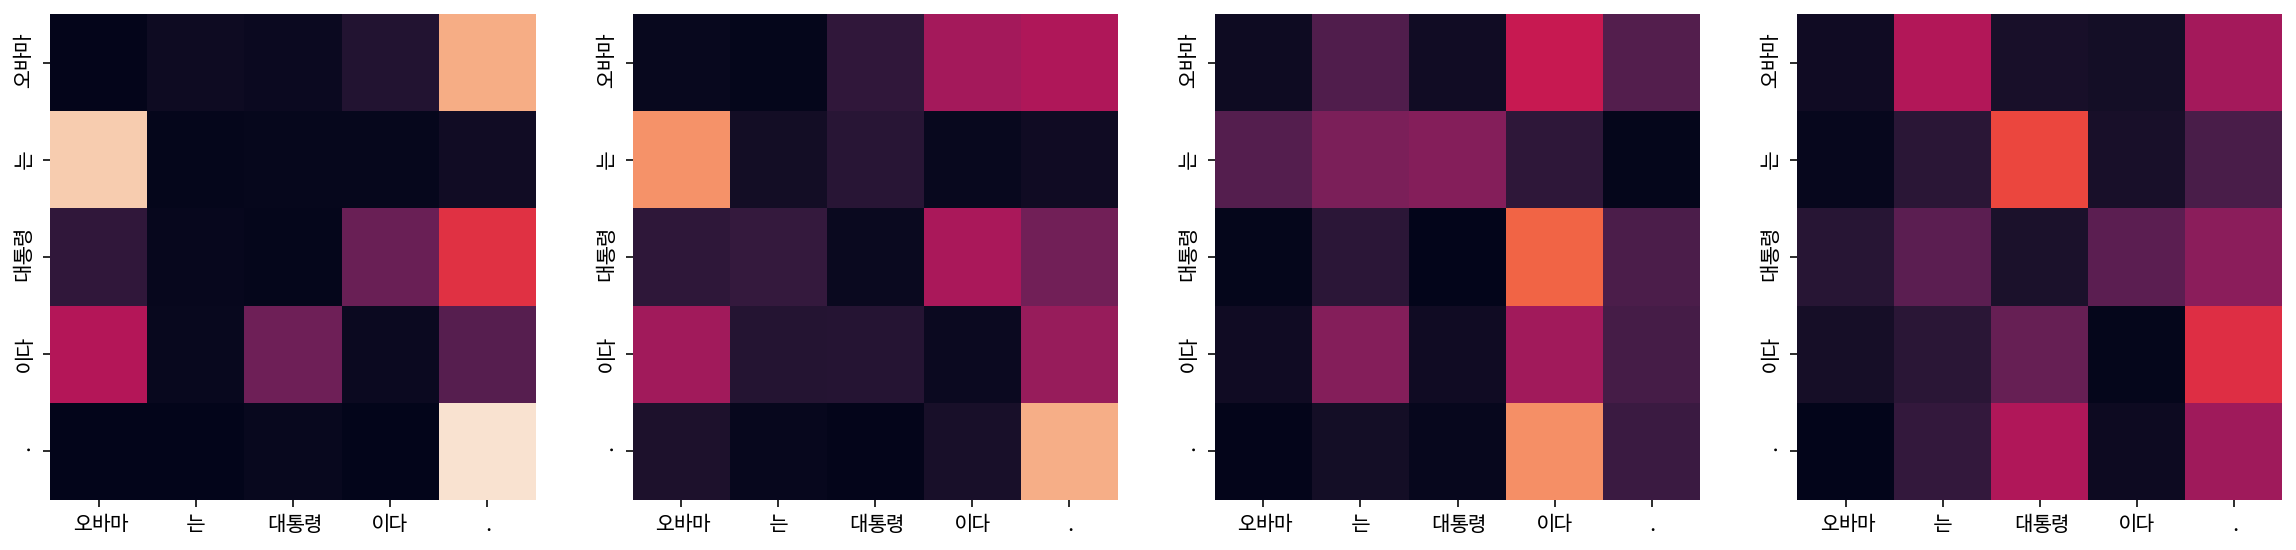

Encoder Layer 2


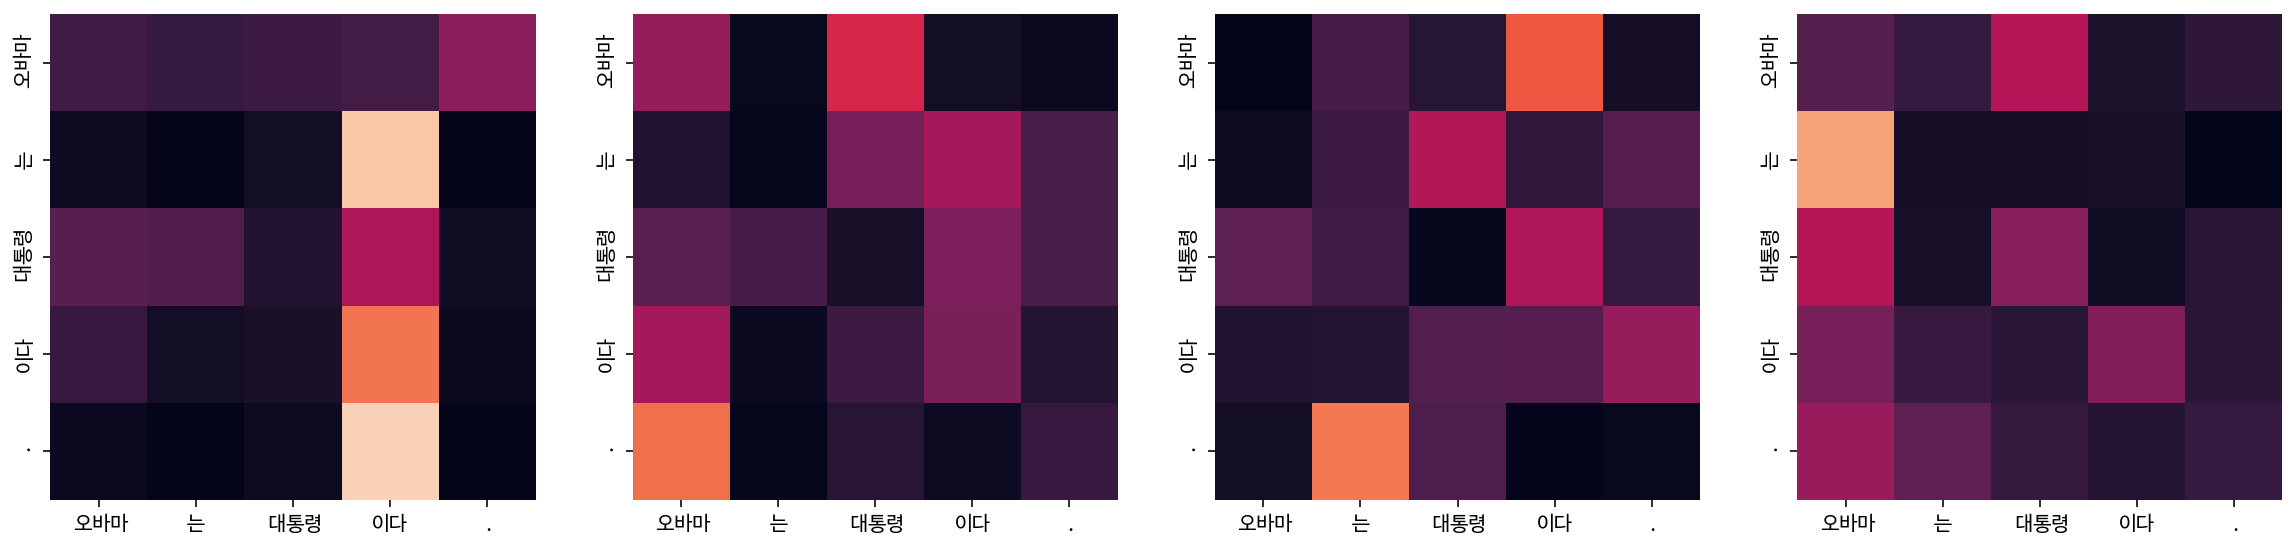

Decoder Self Layer 1


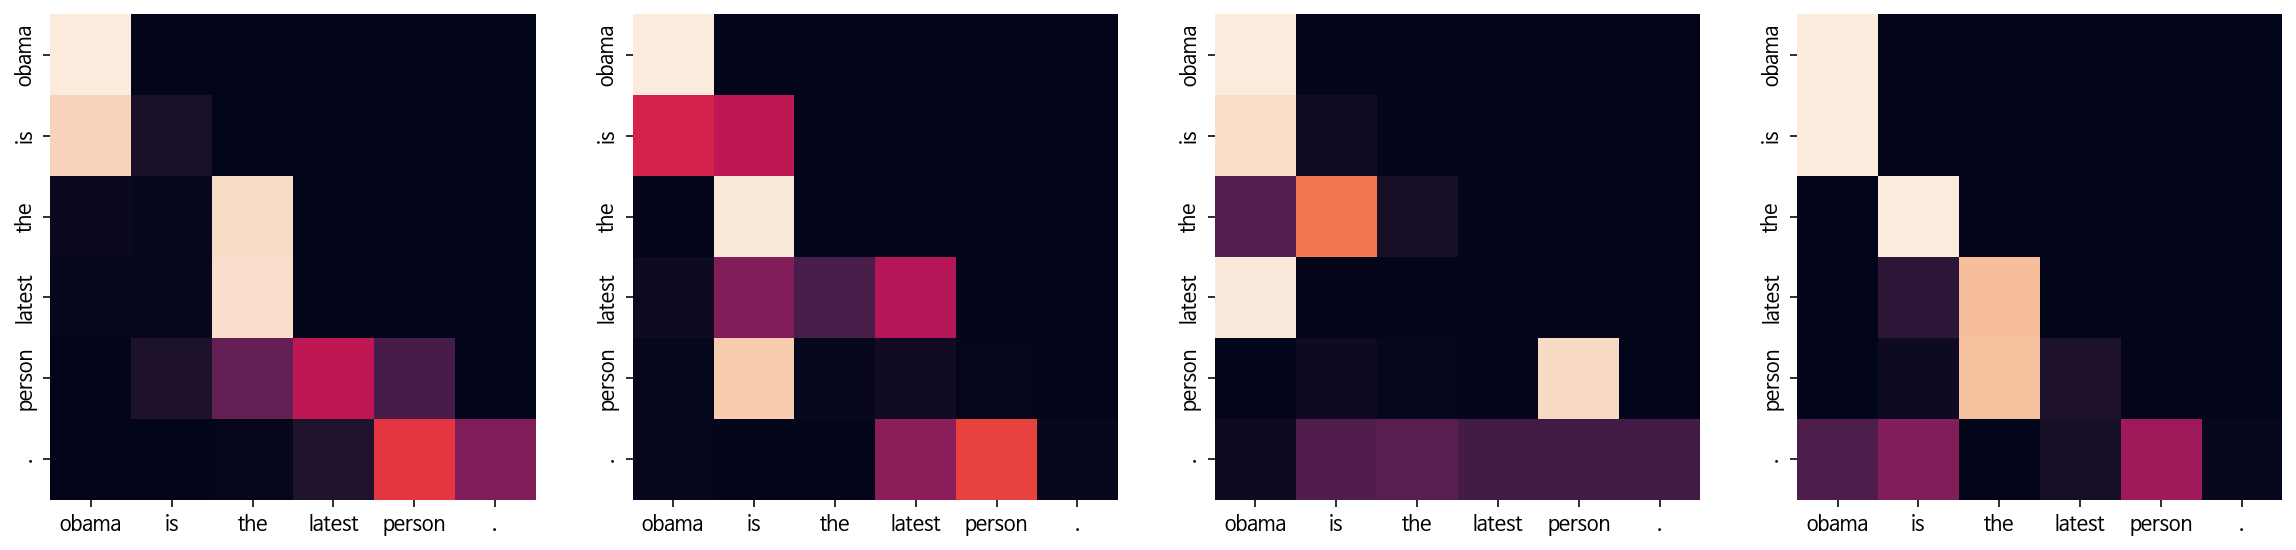

Decoder Src Layer 1


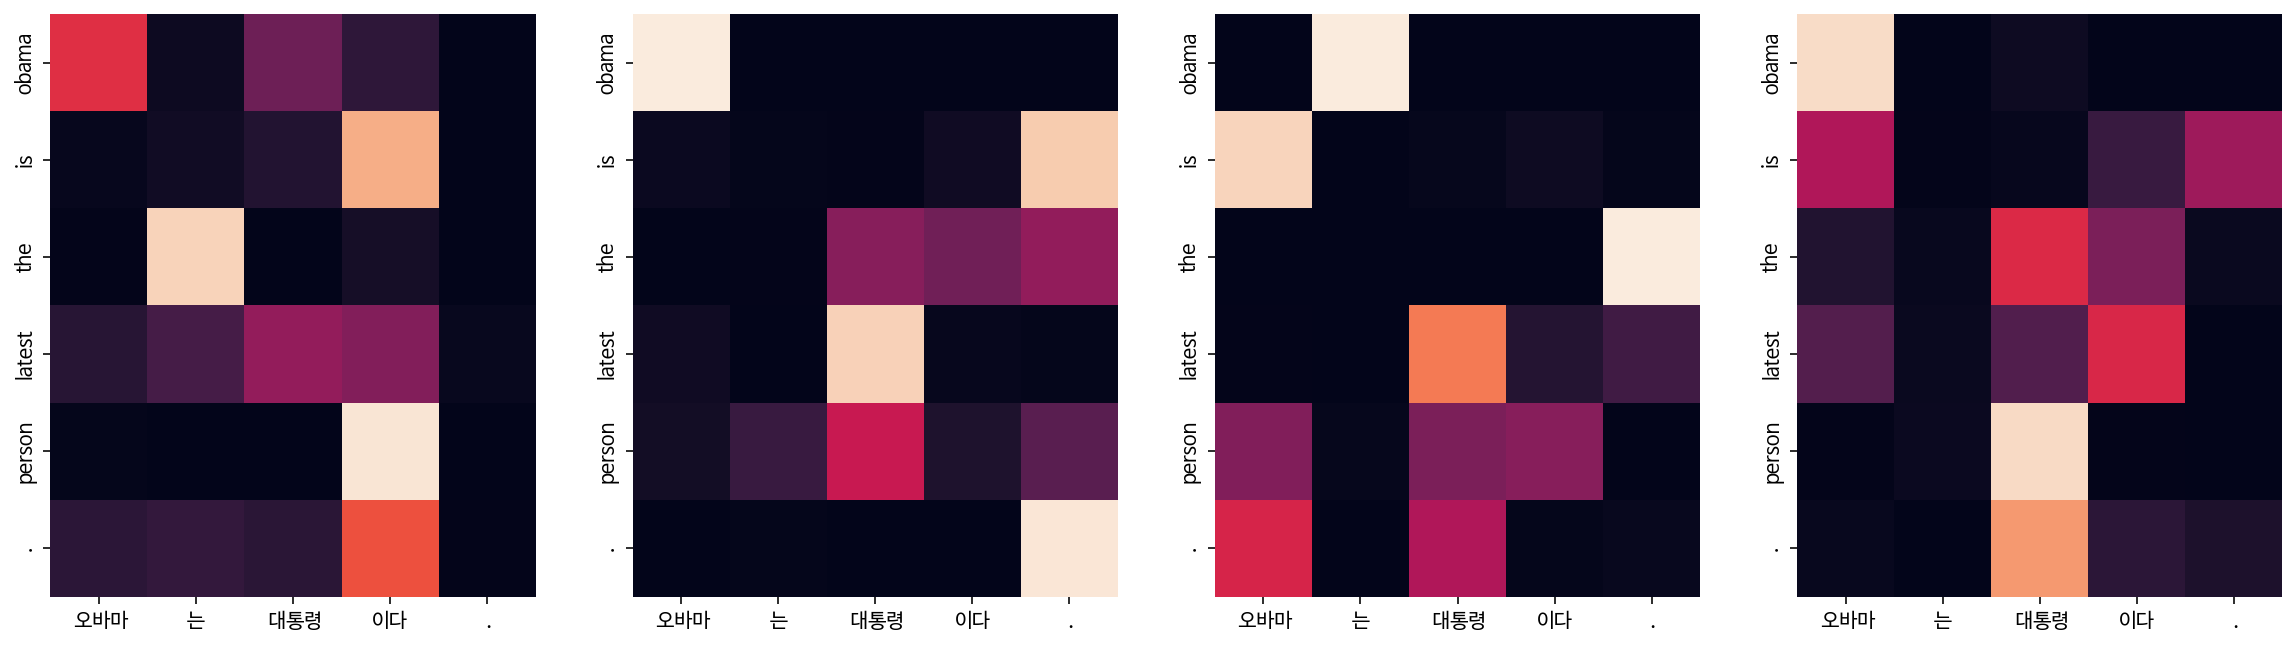

Decoder Self Layer 2


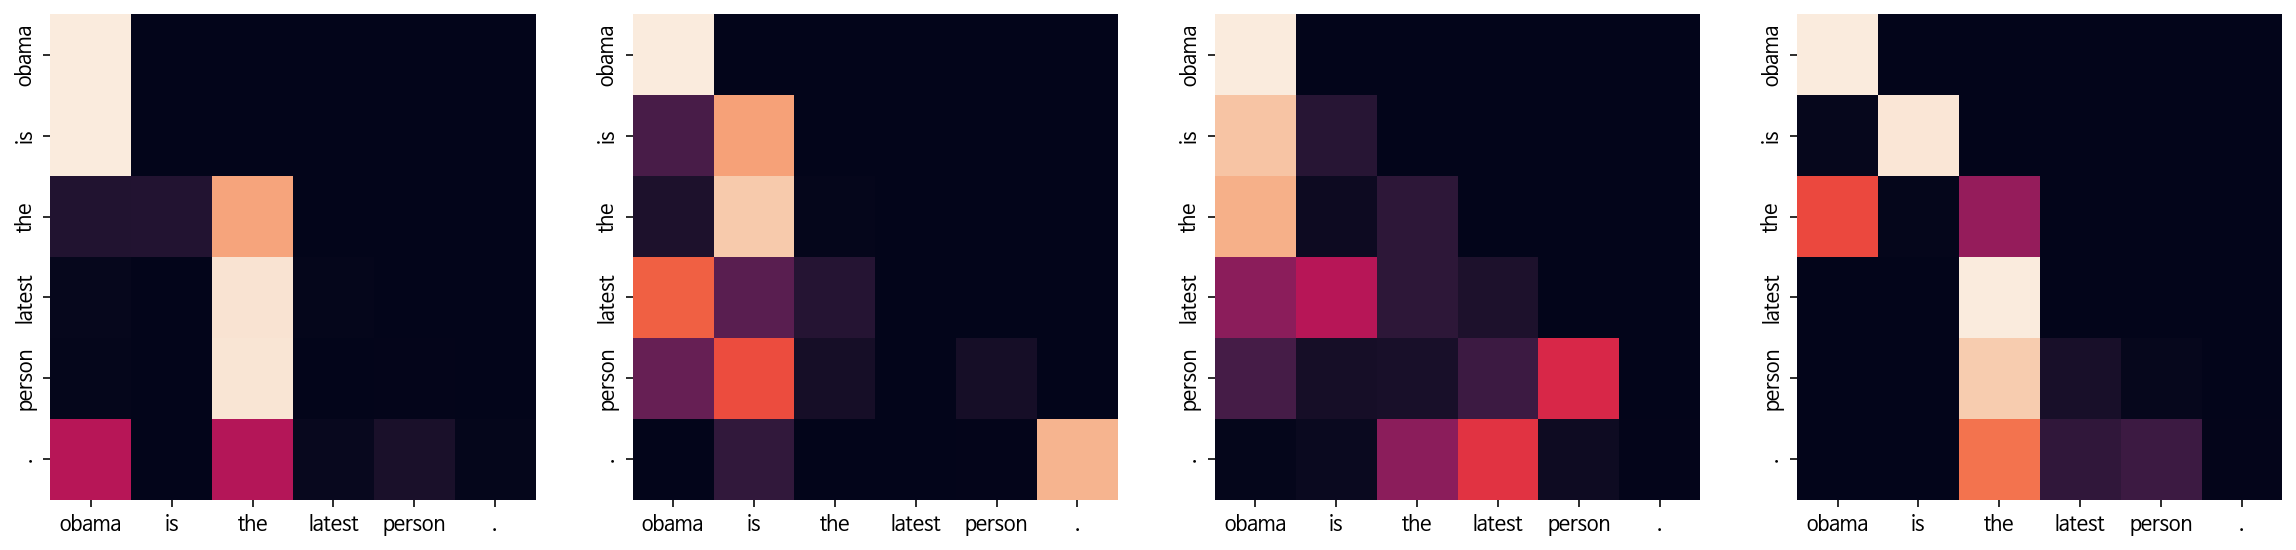

Decoder Src Layer 2


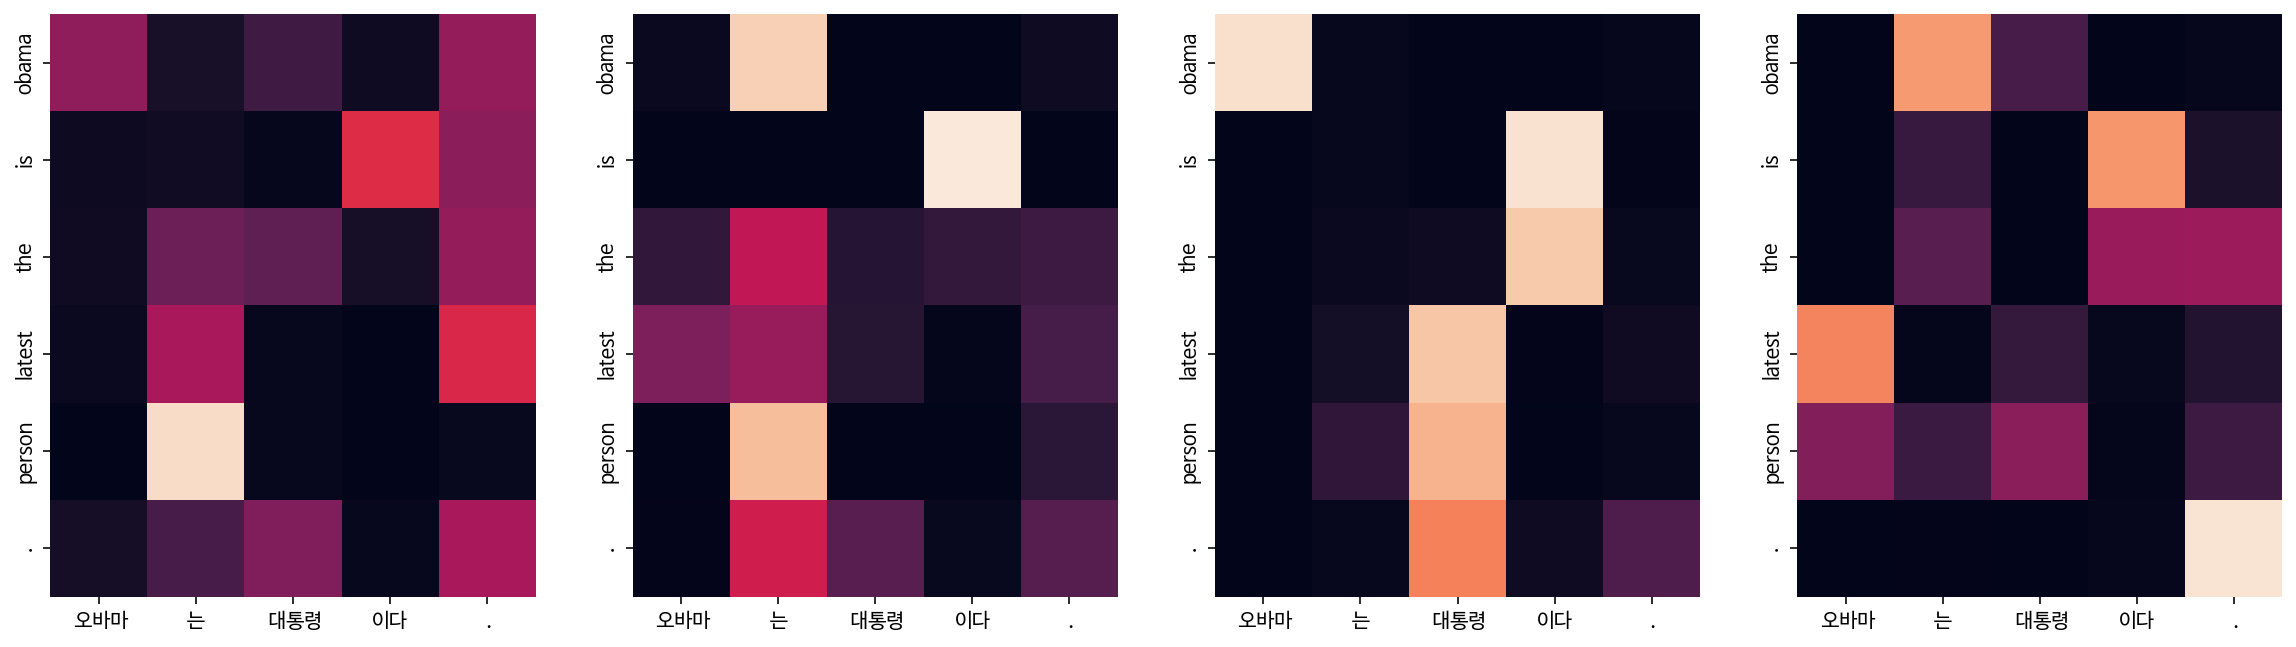

In [40]:
# 번역 결과 시각화

# 오바마는 대통령이다.
translate('오바마는 대통령이다.',transformer, ko_tokenizer, en_tokenizer,True)

# 회고
앞서 만들었던 seq2seq와 차이를 느낄수 있었음. seq2seq은 내가 잘못해서 그런지 시각화 할때 이상하게 글자수가 많이 나오고 반복되는 이상한 상황이 나왔는데 여기선 괜찮게 나옴. 그리고 에포크되는 번역 부분을 봤을때 훨씬 나은점을 확인할수 있음. 하지만 돌아갈때마다 점점 좋아지는 거는 아니고 계속 문장을 새롭게 만들어 내는거 같은 느낌. 의미를 알수있는 문장을 생성해냄